# Classification Model Building

What this model should do:

    - The model will be fed pre-processed WoWChatlog.txt that will be transformed into a CSV file for model processing via pandas.

## Imports

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
import time


SEED = 22




## Setup

In [2]:
%store -r cm_df_token
df = cm_df_token

In [4]:
df

,date,time,text,sentiment,target,text_tokenized,joined_tokens
0,2/22/2022,8:14:35 AM,how long will downtime be,Other,Game,"[long, downtime]",long downtime
1,2/22/2022,8:14:40 AM,8 hours,Other,Game,[hours],hours
2,2/22/2022,8:14:42 AM,few hours,Other,Game,[hours],hours
3,2/22/2022,8:14:42 AM,8 hours?,Negative,Game,[hours],hours
4,2/22/2022,8:14:42 AM,7hrs,Other,Game,[other],other
...,...,...,...,...,...,...,...
2950,2/23/2022,10:17:02 PM,tank and healer looking for late night raidin...,Other,Service,"[tank, healer, looking, late, night, raiding, ...",tank healer looking late night raiding guild pst
2951,2/23/2022,10:17:06 PM,>>one more rep<< need more motivation to get ...,Other,Service,"[one, rep, need, motivation, get, last, rep, g...",one rep need motivation get last rep get aotc ...
2952,2/23/2022,10:18:21 PM,wts spectral tiger cub,Other,Service,"[wts, spectral, tiger, cub]",wts spectral tiger cub
2953,2/23/2022,10:21:11 PM,wts +15 with my team 2500 io timed!,Other,Service,"[wts, team, io, timed]",wts team io timed


In [63]:
X = df.joined_tokens
y = df.target

model_perf = {}
model_labels = ['Chat', 'Game', 'Service']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=22)


In [78]:
def run_model(estimator, X_train, y_train, X_test, y_test, cv):

  start = time.time()
  pipe = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', estimator)
      ])
  
  pipe.fit(X_train, y_train)
  end = time.time()

  cv_acc = round(np.mean(cross_val_score(pipe, X_train, y_train, cv= cv, scoring='accuracy')),4)


  y_pred = pipe.predict(X_test)

  test_acc = round(accuracy_score(y_pred, y_test), 4)
  
  runtime = round((end-start), 4)

  cv_dict = {'CV_Accuracy': cv_acc, 'Test_Accuracy': test_acc, 'Run Time': runtime}


  return( pipe, cv_dict, y_pred)




## Base Models

In [79]:
sgd = SGDClassifier(random_state=SEED)
svc = SVC(random_state=SEED)
lr = LogisticRegression(random_state=SEED)
nb = MultinomialNB()
rf = RandomForestClassifier(random_state=SEED)

models = {'SGD': sgd, 'SVC': svc, 'LogReg': lr, 'Naive': nb, 'RFC': rf}


Showing results for: SGD
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=22))]), 'Performace': {'CV_Accuracy': 0.7189, 'Test_Accuracy': 0.7185, 'Run Time': 0.042}}

Showing results for: SVC
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(random_state=22))]), 'Performace': {'CV_Accuracy': 0.7139, 'Test_Accuracy': 0.7321, 'Run Time': 0.434}}

Showing results for: LogReg
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=22))]), 'Performace': {'CV_Accuracy': 0.7234, 'Test_Accuracy': 0.7321, 'Run Time': 0.241}}

Showing results for: Naive
{'Model': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())]), 'Performace': {'CV_Accuracy': 0.7193, 'Test_Accuracy': 0.7348, 'Run Time': 0.037}}


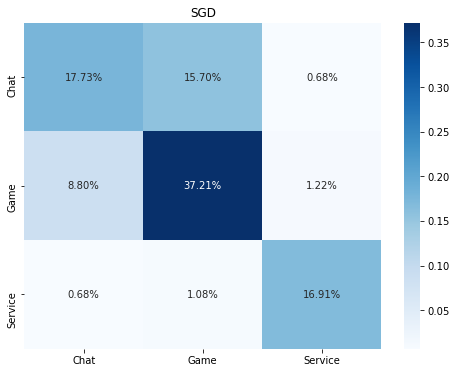

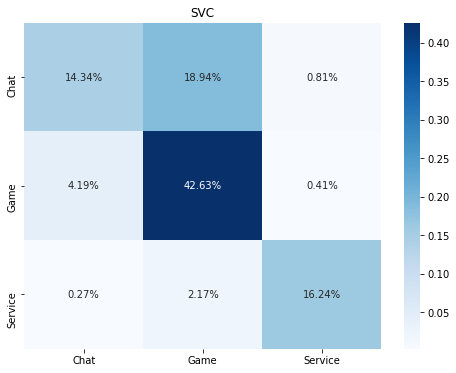

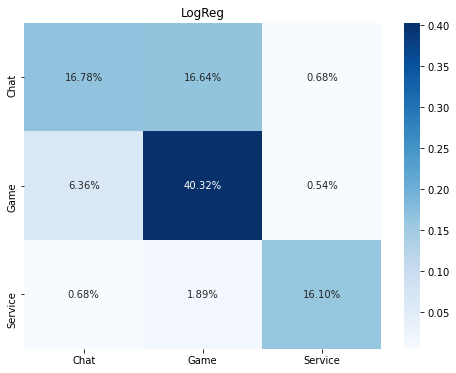

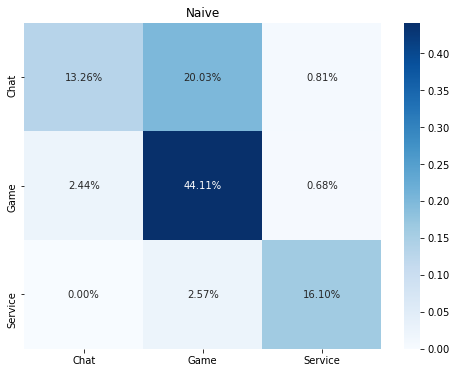

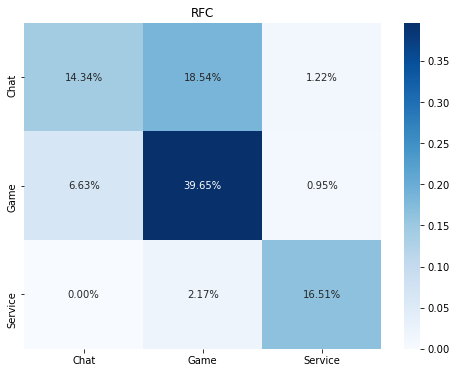

In [80]:
for key, model in models.items():

    model, cv_dict, y_pred = run_model(model, X_train, y_train, X_test, y_test, 5)
    model_perf[key] = {'Model': model, 'Performace': cv_dict}

    print(f'Showing results for: {key}')
    print(model_perf[key])
    print()

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))

    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
    ax.set_title(key);




In [60]:
y_test.value_counts()

Game       349
Chat       252
Service    138
Name: target, dtype: int64

In [69]:
y_test.value_counts(normalize=True)

Game       0.472260
Chat       0.341001
Service    0.186739
Name: target, dtype: float64

## Tuned Models

In [87]:
sgd_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__loss': ['hinge','log','modified_huber','squared_hinge'],
    'clf__max_iter':[1000,2000],
    'clf__class_weight': [None, 'balanced']
}

svc_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__C': [1,5,10],
    'clf__kernel': ['linear','poly', 'rbf', 'sigmoid','precomputed'],
    'clf__degree': [3,6,9],
    'clf__gamma': ['auto', 'scale'],
    'clf__class_weight':[None, 'balanced']
}

lr_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__C': [1,5,10],
    'clf__solver': ['liblinear','lbfgs', 'sag', 'saga','newton-cg'],
    'clf__class_weight': ['balanced', None],
    'clf__multi_class': ['auto', 'ovr', 'multinomial'],
    'clf__penalty':['l1','l2','elasticnet', 'none']
}

nb_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False]
}

rf_params = {
    'vect__strip_accents':[None,'ascii','unicode'],
    'vect__lowercase': [True, False],
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__smooth_idf': [True, False],
    'clf__n_estimators': [100,200,300,400,500],
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [1,3,5],
    'clf__class_weight': [None,'balanced', 'balanced_subsample']
}

In [88]:
def grid_run(estimator, est_params, X_train, y_train, X_test, y_test, cv, score='accuracy'):

  model, cv_dict, y_pred = run_model(estimator, X_train, y_train, X_test, y_test, cv)

  grid = GridSearchCV(model,param_grid= est_params, cv=cv, verbose=1, n_jobs=-3, scoring= score)
  grid = grid.fit(X_train, y_train)

  return(grid)


     

In [91]:
model_params = {'SGD':{sgd:sgd_params}, 'SVC': {svc:svc_params}, 'LogReg': {lr:lr_params}, 'Naive': {nb:nb_params}, 'RFC': {rf:rf_params}}

In [92]:
for key, estimators in model_params.items():
  for estimator, params in estimators.items():

    print('----------------------------------------------')
    print(f'Now running {key} GridSearch')

    grid = grid_run(estimator, params, X_train, y_train, X_test, y_test, 5)

    print()
    print(grid.best_score_)
    print(grid.best_params_)
    print()

----------------------------------------------
Now running SGD GridSearch
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-3)]: Done 430 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-3)]: Done 780 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-3)]: Done 1230 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-3)]: Done 1780 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-3)]: Done 2430 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 2880 out of 2880 | elapsed:  1.6min finished



0.7454782095865616
{'clf__class_weight': 'balanced', 'clf__loss': 'log', 'clf__max_iter': 1000, 'tfidf__smooth_idf': False, 'vect__lowercase': True, 'vect__ngram_range': (1, 1), 'vect__strip_accents': None}

----------------------------------------------
Now running SVC GridSearch
Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-3)]: Done 430 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-3)]: Done 780 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-3)]: Done 1320 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 1960 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-3)]: Done 2620 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-3)]: Done 3450 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-3)]: Done 4390 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-3)]: Done 5520 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-3)]: Done 6660 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-3)]: Done 7850 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-3)]: Done 9280 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-3)]: Done 10720 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-3)]: Done 12330 tasks     


0.7418786732556484
{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__degree': 3, 'clf__gamma': 'auto', 'clf__kernel': 'linear', 'tfidf__smooth_idf': True, 'vect__lowercase': True, 'vect__ngram_range': (1, 2), 'vect__strip_accents': None}

----------------------------------------------
Now running LogReg GridSearch
Fitting 5 folds for each of 12960 candidates, totalling 64800 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-3)]: Done 340 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-3)]: Done 840 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-3)]: Done 1340 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-3)]: Done 1790 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-3)]: Done 2800 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-3)]: Done 3520 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-3)]: Done 4550 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-3)]: Done 5540 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-3)]: Done 6990 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-3)]: Done 8570 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-3)]: Done 10250 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-3)]: Done 11960 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-3)]: Done 13830 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-3)]: Done 15720 tasks  


0.7486354300124051
{'clf__C': 5, 'clf__class_weight': 'balanced', 'clf__multi_class': 'auto', 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__smooth_idf': True, 'vect__lowercase': True, 'vect__ngram_range': (1, 1), 'vect__strip_accents': None}

----------------------------------------------
Now running Naive GridSearch
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-3)]: Done 180 out of 180 | elapsed:    2.6s finished



0.7193093770971876
{'tfidf__smooth_idf': True, 'vect__lowercase': True, 'vect__ngram_range': (1, 1), 'vect__strip_accents': None}

----------------------------------------------
Now running RFC GridSearch
Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-3)]: Done 430 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-3)]: Done 780 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-3)]: Done 1230 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-3)]: Done 1780 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-3)]: Done 2430 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-3)]: Done 3180 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-3)]: Done 4030 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-3)]: Done 4980 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-3)]: Done 6030 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-3)]: Done 7180 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-3)]: Done 8430 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-3)]: Done 9780 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-3)]: Done 11230 tasks      


0.6295161979134891
{'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__n_estimators': 400, 'tfidf__smooth_idf': True, 'vect__lowercase': True, 'vect__ngram_range': (1, 1), 'vect__strip_accents': None}



In [ ]:
def run_model(estimator, X_train, y_train, X_test, y_test, cv):

  start = time.time()
  pipe = Pipeline(
      [ ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', estimator)
      ])
  
  pipe.fit(X_train, y_train)
  end = time.time()

  cv_acc = round(np.mean(cross_val_score(pipe, X_train, y_train, cv= cv, scoring='accuracy')),4)


  y_pred = pipe.predict(X_test)

  test_acc = round(accuracy_score(y_pred, y_test), 4)
  
  runtime = round((end-start), 4)

  cv_dict = {'CV_Accuracy': cv_acc, 'Test_Accuracy': test_acc, 'Run Time': runtime}


  return( pipe, cv_dict, y_pred)

In [94]:
# {'clf__class_weight': 'balanced', 
# 'clf__loss': 'log', 
# 'clf__max_iter': 1000, 
# 'tfidf__smooth_idf': False, 
# vect__lowercase': True, 
# 'vect__ngram_range': (1, 1), 
# 'vect__strip_accents': None}

sgd = Pipeline(
    [   ('vect', CountVectorizer(ngram_range=(1,1))),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='log', class_weight = 'balanced', random_state=SEED))
    ])


sgd.fit(X_train, y_train)

cv_acc = round(np.mean(cross_val_score(sgd, X_train, y_train, cv= 5, scoring='accuracy')),4)

y_pred = sgd.predict(X_test)

test_acc = round(accuracy_score(y_pred, y_test), 4)

print(cv_acc)
print(test_acc)



0.7446
0.77


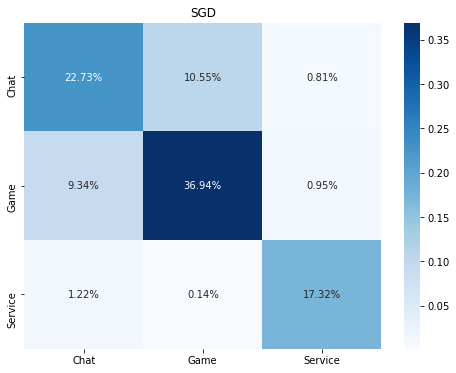

In [96]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
ax.set_title('SGD');

In [109]:
# {'clf__C': 1, 
# 'clf__class_weight': 'balanced', 
# 'clf__degree': 3, 
# 'clf__gamma': 'auto', 
# 'clf__kernel': 'linear', 
# 'tfidf__smooth_idf': True, 
# 'vect__lowercase': True, 
# 'vect__ngram_range': (1, 2), 
# 'vect__strip_accents': None}

svc = Pipeline(
    [   ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(C=1, class_weight = 'balanced', degree = 3, gamma = 'auto', kernel= 'linear',random_state=SEED))
    ])


svc.fit(X_train, y_train)

cv_acc = round(np.mean(cross_val_score(svc, X_train, y_train, cv= 5, scoring='accuracy')),4)

y_pred = svc.predict(X_test)

test_acc = round(accuracy_score(y_pred, y_test), 4)

print(cv_acc)
print(test_acc)

0.7419
0.7618


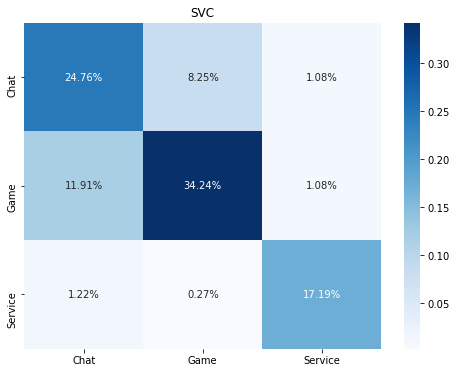

In [110]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
ax.set_title('SVC');

In [100]:
# {'clf__C': 5, 
# 'clf__class_weight': 'balanced', 
# 'clf__multi_class': 'auto', 
# 'clf__penalty': 'l2', 
# 'clf__solver': 'liblinear', 
# 'tfidf__smooth_idf': True, 
# 'vect__lowercase': True, 
# 'vect__ngram_range': (1, 1), 
# 'vect__strip_accents': None}

lg = Pipeline(
    [   ('vect', CountVectorizer(ngram_range=(1,1))),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(C=5, class_weight = 'balanced', multi_class= 'auto', penalty = 'l2', solver= 'liblinear', random_state=SEED))
    ])


lg.fit(X_train, y_train)

cv_acc = round(np.mean(cross_val_score(lg, X_train, y_train, cv= 5, scoring='accuracy')),4)

y_pred = lg.predict(X_test)

test_acc = round(accuracy_score(y_pred, y_test), 4)

print(cv_acc)
print(test_acc)

0.7486
0.774


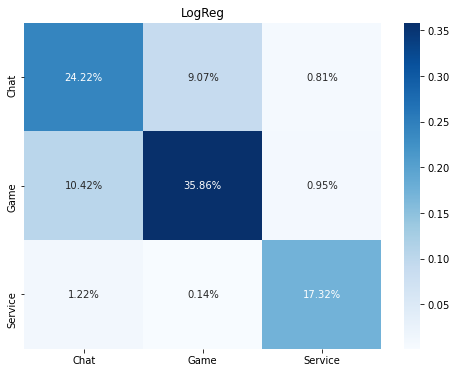

In [101]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels= model_labels, yticklabels= model_labels)
ax.set_title('LogReg');

In [108]:
test_rec = round(recall_score(y_pred, y_test, average='micro'), 4)
test_rec

0.774

In [105]:
test_rec = round(precision_score(y_pred, y_test, average='micro'), 4)
test_rec

0.774

In [106]:
test_rec = round(accuracy_score(y_pred, y_test), 4)
test_rec

0.774